In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


# Scripts for generating events and running environment

In [2]:
from datetime import datetime, timedelta
import os
import pytz

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")

from sustaingym.data.load_moer import load_monthly_moer
from sustaingym.envs.evcharging import EVChargingEnv, RealTraceGenerator, GMMsTraceGenerator, DiscreteActionWrapper
from sustaingym.algorithms.evcharging.baselines import GreedyAlgorithm, MPC, RandomAlgorithm, RLAlgorithm, OfflineOptimal
from sustaingym.envs.evcharging.ev_charging_multiagent import MultiAgentEVChargingEnv

test_ranges = (
    ('2019-05-01', '2019-08-31'),
    ('2019-09-01', '2019-12-31'),
    ('2020-02-01', '2020-05-31'),
    ('2021-05-01', '2021-08-31'),
)


## Run environment Simple

In [6]:
env = EVChargingEnv(RealTraceGenerator('caltech', test_ranges[0]))

done = False
obs, episode_info = env.reset(seed=100, return_info=True)
steps = 0
while not done:
    action = np.ones((54,))
    obs, reward, terminated, truncated, info = env.step(action, return_info=True)
    if steps==100:
        print(info.keys())
    done = terminated or truncated
    steps += 1

print(steps)
print(info.keys())
print(info['reward_breakdown'])

dict_keys(['num_evs', 'avg_plugin_time', 'max_profit', 'reward_breakdown', 'evs', 'active_evs', 'moer', 'pilot_signals'])
288
dict_keys(['num_evs', 'avg_plugin_time', 'max_profit', 'reward_breakdown', 'evs', 'active_evs', 'moer', 'pilot_signals'])
{'profit': 5.689446962941684, 'carbon_cost': 1.4659707465512641, 'excess_charge': 0.0}


## Real trace generator + GMMs trace generator

In [7]:
# Check able to generate on all days
for site in ['caltech', 'jpl']:
    for test_range in test_ranges:
        print('testing: ', site, test_range)
        rtg = RealTraceGenerator(site, test_range)
        for _ in range(123):  # 4 months -> 123 days maximum
            _, _, num_plug_events = rtg.get_event_queue()
        print(rtg)


for site in ['caltech', 'jpl']:
    for test_range in test_ranges:
        print('testing: ', site, test_range)
        gmmg = GMMsTraceGenerator(site, test_range)
        for _ in range(123):  # 4 months -> 123 days maximum
            _, _, num_plug_events = gmmg.get_event_queue()
        print(gmmg)

testing:  caltech ('2019-05-01', '2019-08-31')
Real trace generator for Caltech garage (2019-05-01 to 2019-08-31)
Sequential = True, Use unclaimed = False
Current day: 2019-08-31
testing:  caltech ('2019-09-01', '2019-12-31')
Real trace generator for Caltech garage (2019-09-01 to 2019-12-31)
Sequential = True, Use unclaimed = False
Current day: 2019-09-01
testing:  caltech ('2020-02-01', '2020-05-31')
Real trace generator for Caltech garage (2020-02-01 to 2020-05-31)
Sequential = True, Use unclaimed = False
Current day: 2020-02-02
testing:  caltech ('2021-05-01', '2021-08-31')
Real trace generator for Caltech garage (2021-05-01 to 2021-08-31)
Sequential = True, Use unclaimed = False
Current day: 2021-08-31
testing:  jpl ('2019-05-01', '2019-08-31')
Real trace generator for JPL garage (2019-05-01 to 2019-08-31)
Sequential = True, Use unclaimed = False
Current day: 2019-08-31
testing:  jpl ('2019-09-01', '2019-12-31')
Real trace generator for JPL garage (2019-09-01 to 2019-12-31)
Sequent

# Checking the Environment makes sense
- sanity check on rewards for policies
- seed setting
- printing, __repr__, step, reset, render, close
- discrete action wrapper

# Basic
Run selective full charge on environment

In [3]:
env = EVChargingEnv(GMMsTraceGenerator('caltech', test_ranges[0]))
print('--- Print environment ---')
print(repr(env))
done = False

obs = env.reset(seed=100)
steps = 0
while not done:
    action = np.where(obs['demands'] > 0, 1, 0)
    obs, reward, done, info = env.step(action, return_info=True)
    steps += 1

try:
    env.render()
except NotImplementedError:
    print("Render is not implemented as expected")
env.close()

print("--- Number of steps taken ---")
print(steps)

print("--- Print keys for info ---")
print(info.keys())
# print('evs: ', info['evs'])
print('num_evs: ', info['num_evs'])
print('avg_plugin_time: ', info['avg_plugin_time'])
print('max_profit: ', info['max_profit'])
print('reward_breakdown: ', info['reward_breakdown'])
print('moer: ', info['moer'])
print('active_evs: ', info['active_evs'])
print('pilot_signals: ', info['pilot_signals'])


--- Print environment ---
EVChargingGym (action projection = True, moer forecast steps = 36) using 30-component GMM-based trace generator for Caltech garage (2019-05-01 to 2019-08-31)

Render is not implemented as expected
--- Number of steps taken ---
288
--- Print keys for info ---
dict_keys(['num_evs', 'avg_plugin_time', 'max_profit', 'reward_breakdown', 'evs', 'active_evs', 'moer', 'pilot_signals'])
num_evs:  8
avg_plugin_time:  16.25
max_profit:  1.937169194116585
reward_breakdown:  {'profit': 1.9349932725049772, 'carbon_cost': 0.4211193554271963, 'excess_charge': 0.0}
moer:  [[0.25093102 0.25882171 0.26365876 ... 0.23125312 0.22159009 0.23158045]
 [0.27693341 0.26471076 0.26441379 ... 0.22159009 0.23158045 0.22436101]
 [0.27693341 0.27053079 0.26710011 ... 0.23158045 0.22436101 0.22028979]
 ...
 [0.44068568 0.46343725 0.42587781 ... 0.22532771 0.22532077 0.22603387]
 [0.39955963 0.41700278 0.40441051 ... 0.22532077 0.22603387 0.22367995]
 [0.38244118 0.38845881 0.37314782 ... 0.2

## Rewards from policies

In [5]:
policies = ['random', 'full', 'selective_full']
env1 = EVChargingEnv(RealTraceGenerator('caltech', test_ranges[0]))
env2 = EVChargingEnv(RealTraceGenerator('caltech', test_ranges[0]), project_action_in_env=False)

np.random.seed(42)
random_action = np.random.randint(0, 5, size=(54,)).astype(float) / 4

for policy in policies:
    for env in [env1, env2]:
        num_episodes = 1
        rewards = []
        reward_comps = {'profit': 0, 'carbon_cost': 0, 'excess_charge': 0}
        for _ in range(num_episodes):
            obs, info = env.reset(seed=43, return_info=True)
            done = False
            tot_reward = 0
            timestep = 0
            while not done:
                timestep += 1
                if policy == 'random':
                    action = random_action
                elif policy == 'full':
                    action = np.full((54,), 1)
                elif policy == 'none':
                    action = np.zeros((54,))
                else:
                    action = np.where(obs['demands'] > 0, 1, 0)
                obs, reward, done, info = env.step(action)

                tot_reward += reward
                # for reward_comp in info['reward']:
                #     reward_comps[reward_comp] += info['reward'][reward_comp]
            rewards.append(tot_reward)
        print(f'{policy} {env.project_action_in_env}')
        
        rd = info['reward_breakdown']
        print("Outside: ", tot_reward, "Inside: ", rd['profit'] - rd['carbon_cost'] - rd['excess_charge'])
        print("Best possible: ", info['max_profit'])
        print('reward components:', info['reward_breakdown'])  # total reward contribution over num_episodes


random True
Outside:  12.008392211344626 Inside:  12.008392211344628
Best possible:  18.190599999999996
reward components: {'profit': 13.996691254310287, 'carbon_cost': 1.9882990429656593, 'excess_charge': 0.0}
random False
Outside:  8.285198410819875 Inside:  8.285198410819902
Best possible:  18.190599999999996
reward components: {'profit': 14.215788311091455, 'carbon_cost': 2.0186516889044586, 'excess_charge': 3.911938211367094}
full True
Outside:  15.010683752125395 Inside:  15.010683752125392
Best possible:  18.190599999999996
reward components: {'profit': 17.43604502439515, 'carbon_cost': 2.425309272269757, 'excess_charge': 5.2e-05}
full False
Outside:  1.1938053557307131 Inside:  1.1938053557307402
Best possible:  18.190599999999996
reward components: {'profit': 18.19033245209323, 'carbon_cost': 2.5183740207386727, 'excess_charge': 14.478153075623817}
selective_full True
Outside:  15.010683752125395 Inside:  15.010683752125392
Best possible:  18.190599999999996
reward components:

## Check seed setting is done correctly

In [3]:
generators = []
for sequential in [False, True]:
    gen = RealTraceGenerator('caltech', test_ranges[1], sequential=sequential)
    generators.append(gen)

gen = GMMsTraceGenerator('caltech', test_ranges[1])
generators.append(gen)

for gen in generators:
    print('--- ', gen)
    for seed in [None, 11]:
        print(f'seed is {seed}')
        for _ in range(3):
            gen.set_seed(seed)
            days = []
            for _ in range(7):
                _, _, num_event = gen.get_event_queue()
                days.append(gen.day.strftime("%m/%d"))
            print(days)

---  Real trace generator for Caltech garage (2019-09-01 to 2019-12-31)
Sequential = False, Use unclaimed = False
Current day: 2019-12-21
seed is None
['11/12', '10/02', '12/25', '12/03', '10/30', '11/07', '10/13']
['12/07', '09/13', '09/29', '10/26', '12/16', '11/22', '11/21']
['11/02', '09/25', '09/21', '09/22', '12/15', '09/17', '12/25']
seed is 11
['09/17', '09/16', '12/07', '10/31', '11/11', '11/13', '11/26']
['09/17', '09/16', '12/07', '10/31', '11/11', '11/13', '11/26']
['09/17', '09/16', '12/07', '10/31', '11/11', '11/13', '11/26']
---  Real trace generator for Caltech garage (2019-09-01 to 2019-12-31)
Sequential = True, Use unclaimed = False
Current day: 2019-08-31
seed is None
['09/01', '09/02', '09/03', '09/04', '09/05', '09/06', '09/07']
['09/08', '09/09', '09/10', '09/11', '09/12', '09/13', '09/14']
['09/15', '09/16', '09/17', '09/18', '09/19', '09/20', '09/21']
seed is 11
['09/13', '09/14', '09/15', '09/16', '09/17', '09/18', '09/19']
['09/13', '09/14', '09/15', '09/16', 

## Discrete Action Wrapper

In [4]:
env = DiscreteActionWrapper(EVChargingEnv(RealTraceGenerator('caltech', test_ranges[0])))

action = np.random.randint(0, 5, size=(54,))

done = False
obs, episode_info = env.reset(seed=100, return_info=True)
steps = 0
while not done:
    obs, reward, done, info = env.step(action)
    steps += 1

print(steps)
print(info['reward_breakdown'])

288
{'profit': 1.154316195320061, 'carbon_cost': 0.26689543185041137, 'excess_charge': 0.0}


## Easy Algorithms

In [3]:
env_discrete = DiscreteActionWrapper(EVChargingEnv(RealTraceGenerator('caltech', test_ranges[2])))
env_continuous = EVChargingEnv(RealTraceGenerator('caltech', test_ranges[2]))

algorithms = {
    'random': RandomAlgorithm,
    'mpc': MPC,
    'greedy': GreedyAlgorithm,
}

for k in algorithms:
    for action_type, env in zip(['discrete', 'continuous'], [env_discrete, env_continuous]):
        try:
            algorithm = algorithms[k](env)

            reward_breakdown = algorithm.run(seeds=5)
            print(f'{k}, {action_type}')
            print(reward_breakdown)
        except AssertionError as e:
            print(e)

100%|██████████| 5/5 [00:49<00:00,  9.99s/it]


random, discrete
      reward     profit  carbon_cost  excess_charge  max_profit
0   0.849863   0.948947     0.099084       0.000000     1.59700
1   9.106935  11.143655     2.034605       0.002115    14.45262
2  10.444871  12.370596     1.924754       0.000971    14.66722
3  11.365980  13.249488     1.883491       0.000017    18.29822
4   8.363827   9.920121     1.556295       0.000000    12.16664


  0%|          | 0/5 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [4]:
rb1 = reward_breakdown.copy()
rb2 = reward_breakdown.copy()

In [10]:
pd.concat([pd.DataFrame({}), rb1])

,reward,profit,carbon_cost,excess_charge,max_profit,timestep
0,0.849863,0.948947,0.099084,0.000000,1.59700,25
1,9.106935,11.143655,2.034605,0.002115,14.45262,25
2,10.444871,12.370596,1.924754,0.000971,14.66722,25
3,11.365980,13.249488,1.883491,0.000017,18.29822,25
4,8.363827,9.920121,1.556295,0.000000,12.16664,25


In [8]:
rb1['timestep'] = 25
rb2['timestep'] = 50

In [12]:
np.array(rb1['reward'])

array([ 0.84986308,  9.10693549, 10.444871  , 11.3659798 ,  8.36382668])

## Hard Algorithm: Offline Optimal

In [3]:
env_continuous = EVChargingEnv(RealTraceGenerator('caltech', test_ranges[2]))
oo = OfflineOptimal(env_continuous)

reward_breakdown = oo.run(seeds=[2])
print(reward_breakdown)


  0%|          | 0/1 [00:00<?, ?it/s]

Solving
Done solving


100%|██████████| 1/1 [05:54<00:00, 354.45s/it]

      reward     profit  carbon_cost  excess_charge  max_profit
0  12.490097  14.192275     1.702178            0.0    14.66722


In [ ]:
#       reward     profit  carbon_cost  excess_charge  max_profit
# 0  10.925368  13.099406     2.174038            0.0    14.45262

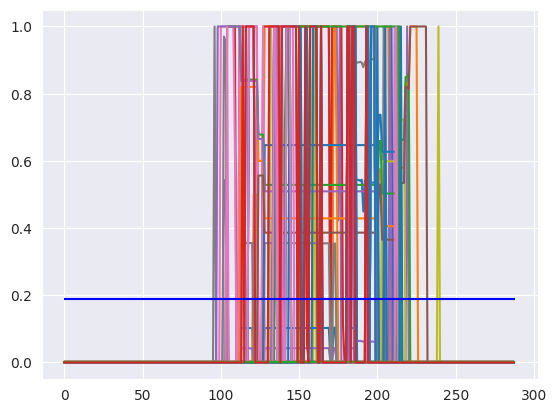

In [11]:
for i in range(54):
    plt.plot(oo.traj.value[i])
plt.hlines(y=6/32, xmin=0, xmax=288, color='b')

In [19]:
print([(ev.remaining_demand, ev.requested_energy, ev.energy_delivered, ev.departure - ev.arrival) for ev in env_continuous.evs])

[(1.1473362721748526, 15.0, 13.852663727825147, 25), (2.2246666666666233, 9.99, 7.765333333333377, 14), (0.3241400947871895, 12.0, 11.67585990521281, 39), (0.37181460817931544, 13.5, 13.128185391820685, 25), (15.83599999999999, 17.5, 1.66400000000001, 3), (1.5626666666666402, 6.0, 4.43733333333336, 8)]


In [18]:
env_continuous.A_PERS_TO_KWH * 32# * env_continuous.ACTION_SCALE_FACTOR

0.5546666666666666

In [ ]:
reward_breakdown.to_csv("test_for_to_csv.csv", compression='gzip', index=False)
rb = pd.read_csv("test_for_to_csv.csv", compression='gzip')

rb.head()

,reward,profit,carbon_cost,excess_charge,max_profit
0,13.054946,15.537122,2.481864,0.000312,17.00234
1,11.003670,13.522248,2.518544,0.000035,14.45262
2,12.053717,14.447530,2.393812,0.000000,14.66722
3,15.023689,17.536750,2.512888,0.000173,18.29822
4,10.182529,12.093955,1.911218,0.000208,12.16664


In [ ]:
import pdb

ga = GreedyAlgorithm(project_action=True)
mpc1 = MPC(lookahead=1)
mpc2 = MPC(lookahead=2)
mpc6 = MPC(lookahead=6)
mpc12 = MPC(lookahead=12)
mpc36 = MPC(lookahead=36)

lbls = ['mpc1']
algs = [mpc1]
# lbls = ['greedy', 'mpc1', 'mpc2', 'mpc6', 'mpc12', 'mpc36']
# algs = [ga, mpc1, mpc2, mpc6, mpc12, mpc36]

DEFAULT_DATE_RANGES = (
    ('2019-05-01', '2019-08-31'),
    ('2019-09-01', '2019-12-31'),
    ('2020-02-01', '2020-05-31'),
    ('2021-05-01', '2021-08-31'),
)

# bug fix: commit 18be9933cbf14e19e17332c9a870f480471eea86
# 2019-08-14: StationOccupiedError: Station CA-303 is occupied with ev 2_39_139_28_2019-08-15 07:07:28.618042.
# 2019-10-25: StationOccupiedError: Station CA-317 is occupied with ev 2_39_91_437_2019-10-26 07:36:37.638121. -> change mask: mask = (self.day.day == max_depart.dt.day) instead of mask = (df['arrival'].dt.day == max_depart.dt.day)
# 2020-03-15: StationOccupiedError: Station CA-303 is occupied with ev 2_39_139_28_2020-03-16 07:51:17.415039.

DATE_FORMAT = '%Y-%m-%d'
def num_days_in_period(xs) -> int:
    """Returns the number of days in period."""
    dts = tuple(datetime.strptime(x, DATE_FORMAT) for x in xs)
    td = dts[1] - dts[0]
    return td.days + 1

for alg, lbl in zip(algs, lbls):
    for season in DEFAULT_DATE_RANGES:
        gen = RealTraceGenerator('caltech', season, sequential=True)
        env = EVChargingEnv(gen)
        rewards, breakdown = alg.run(num_days_in_period(season), env)

        print(f'{lbl} average reward: ', np.mean(rewards))
        print(f'{lbl} rewards: ', rewards)
        print(f'{lbl} reward breakdown: ', breakdown)

100%|██████████| 123/123 [08:28<00:00,  4.13s/it]


mpc1 average reward:  7.410445745394435
mpc1 rewards:  [17.611852001760465, 11.448670037614956, 7.985192220906874, 2.532929820790012, 4.176859627738011, 12.365029189409828, 14.17219046398295, 11.264549520767648, 10.411906492757872, 10.561962344299584, 3.5108945420441184, 3.02229013132516, 16.97669532028571, 11.332930287640055, 11.220862345782631, 12.074439985514118, 14.354725924204056, 3.3824462410599696, 4.525322426872741, 15.721941822425856, 15.589723767711682, 10.710548717430974, 9.325908827321927, 10.041486342215087, 1.5577960668462778, 1.8944209934543916, 3.3740567292451296, 11.393019469259556, 12.041897462487684, 11.9524210946233, 10.337496287665852, 2.156338751693035, 2.552634520257798, 14.155571434432602, 11.589002950875702, 9.953536333828946, 9.83566177896273, 13.401318649880784, 2.36242955768457, 2.1580347025392252, 7.87894504608418, 5.462143927027356, 10.69286232039029, 9.457893157074517, 14.594033671808278, 6.082983311262314, 1.8734046584165327, 8.50700680444646, 10.0031633

100%|██████████| 122/122 [08:55<00:00,  4.39s/it]


mpc1 average reward:  6.952235601416942
mpc1 rewards:  [0.7894010243878143, 2.7265030346381063, 6.61610753573998, 7.665468052922636, 7.827165146129333, 8.04432969120473, 2.4744573238958645, 2.1771152052274836, 14.649042464637708, 8.249903579071134, 9.671667994354133, 9.602741274276582, 7.353805117861956, 3.41740651046765, 1.6172736654832343, 8.487804753640399, 4.590118507453238, 9.050134211639602, 11.550236588056169, 10.4133473417773, 0.9334230032940265, 2.1036614809385576, 13.10871392252195, 7.857973669218443, 8.451251392104956, 10.033600059684902, 10.814211443851745, 0.994100578605656, 2.9008364458881544, 11.40326896461515, 13.395796456187824, 8.952760804200834, 10.893795709596636, 12.534941293593596, 1.7724280456082808, 0.13559649001477792, 11.35602597874921, 11.543417384982018, 9.721650580925044, 10.39003925690486, 8.689221439687659, 3.9857267224679385, 1.2794089121843815, 12.089453484347226, 8.882090228700484, 8.234318249701051, 10.246700925662692, 11.009921924959864, 2.0914770207

100%|██████████| 121/121 [10:19<00:00,  5.12s/it]


mpc1 average reward:  2.821764269448531
mpc1 rewards:  [1.3757655969519373, 2.086546778261297, 10.834143115049326, 11.91075207819866, 14.769309264478313, 10.029833901492848, 12.626465400960143, 2.6132799119339456, 2.7587939386981812, 9.377536626967977, 15.019545302161271, 14.548587543858376, 13.859865476552129, 9.19117512339146, 0.9168226381166227, 1.1510554994240527, 2.5307532702451403, 11.742599686403407, 12.59595948015232, 13.23194005225372, 9.558470626451426, 2.416420534214556, 0.6151990165220479, 8.061383205815305, 9.915439857378988, 10.205381702630099, 10.269805130171445, 9.177516784053216, 3.5513181464955026, 1.123250317702272, 12.53160660073345, 9.485939410681167, 10.169572519874404, 8.61470239587391, 9.972882381651944, 0.9242112779725825, 2.3185855177898036, 9.78961632219427, 6.694243029731545, 8.075630302642615, 4.087244066165285, 2.492654596589272, 0.22001049603635514, 2.25196400913677, 0.861356092089856, 1.4008683880887889, 0.8246101985667648, 0.6996959315997833, 0.0, 0.0, 

100%|██████████| 123/123 [08:42<00:00,  4.25s/it]

mpc1 average reward:  2.186709295304183
mpc1 rewards:  [0.3868741283088463, 0.0, 0.8689697471416109, 3.038588669577814, 2.006021629877654, 1.0813692481363455, 2.786496148885035, 0.4659200000000028, 0.7715734650263332, 1.5080532804422504, 1.639709133606255, 2.8475444091252267, 1.1349194981710715, 2.6781508091157114, 1.0686253237180243, 1.4537429034369589, 1.0146109999317325, 1.8156312243966373, 3.0949829409447496, 1.2548008896697063, 2.0326211361193827, 0.7847458266260414, 0.6742085823639093, 3.4808683581918896, 3.4719871857525386, 1.7973451532230305, 1.2614973425257958, 1.8116667685353471, 0.7589198109571695, 0.4171613755729792, 0.3388366579104569, 1.3448581583718273, 3.426047060715975, 1.7840879438824027, 1.2856618718039485, 1.5035033597699154, 1.9585412392174784, 1.1670225591484862, 0.8035723083879619, 2.423774150243565, 1.8999790326937698, 2.783678967776185, 0.9634725203668606, 0.4734068489513869, 2.649339976113318, 2.177681065276564, 1.3960537734980385, 1.863511198908633, 2.6757977

# Multi-Agent Environment Checking

In [3]:
env = MultiAgentEVChargingEnv(GMMsTraceGenerator('caltech', test_ranges[0]), periods_delay=10)
# print('--- Print environment ---')
# print(repr(env))


done = False

obs = env.reset(seed=100)
steps = 0

while not done:
    action = {}
    for i, agent in enumerate(obs):
        action[agent] = 1 if obs[agent]['demands'][i] > 0 else 0
    obs, reward, truncated, terminated, info = env.step(action, return_info=True)
    done = any(truncated.values()) or any(terminated.values())
    if steps == 4:
        print(obs['CA-148'])
    steps += 1

try:
    env.render()
except NotImplementedError:
    print("Render is not implemented as expected")
env.close()

print("--- Number of steps taken ---")
print(steps)

print("--- Print keys for info ---")
print(info.keys())
# print('evs: ', info['evs'])
print('num_evs: ', info['CA-148']['num_evs'])
print('avg_plugin_time: ', info['CA-148']['avg_plugin_time'])
print('max_profit: ', info['CA-148']['max_profit'])
print('reward_breakdown: ', info['CA-148']['reward_breakdown'])
print('moer: ', info['CA-148']['moer'])
print('active_evs: ', info['CA-148']['active_evs'])
print('pilot_signals: ', info['CA-148']['pilot_signals'])


{'est_departures': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32), 'demands': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32), 'prev_moer': array([0.28326392], dtype=float32), 'forecasted_moer': array([0.28033653, 0.27182642, 0.2594656 , 0.25339308, 0.24500452,
       0.22634545, 0.23107548, 0.23982146, 0.24154581, 0.24082567,
       0.23990938, 0.23818567, 0.2332133 , 0.22814275, 0.22841892,
       0.22684373, 0.22296332, 0.2258602 , 0.23078403, 0.24502796,
       0.24335684, 0.24808389, 0.24661812, 0.23810473, 0.2395588 ,
       0.2348326 , 0.22997987, 0.23004724, 0.

In [4]:
st = 'CA-308'
print(obs[st])
print(reward[st])
print(truncated[st])
print(terminated[st])

{'est_departures': array([0.], dtype=float32), 'demands': array([0.], dtype=float32), 'prev_moer': array([0.38244116], dtype=float32), 'forecasted_moer': array([0.38845882, 0.37314782, 0.35778803, 0.35010257, 0.3415641 ,
       0.27262726, 0.2690506 , 0.26515412, 0.25926077, 0.2543273 ,
       0.25708255, 0.2603892 , 0.24859801, 0.24855122, 0.24853615,
       0.24584204, 0.24582084, 0.24337186, 0.23933677, 0.23505887,
       0.23280773, 0.22523241, 0.22745483, 0.21978432, 0.2309744 ,
       0.2295696 , 0.2319114 , 0.2292741 , 0.22585355, 0.22729668,
       0.2272637 , 0.22532772, 0.22532077, 0.22603387, 0.22367994,
       0.22650369], dtype=float32), 'timestep': array([1.], dtype=float32)}
0.0
True
True


In [6]:
from pettingzoo.test import parallel_api_test

env = MultiAgentEVChargingEnv(GMMsTraceGenerator('caltech', test_ranges[0]))
parallel_api_test(env, num_cycles=1000)

# from pettingzoo.butterfly import pistonball_v6
# env = pistonball_v6.env()
# api_test(env, num_cycles=1000, verbose_progress=False)

In [3]:
from pettingzoo.test.seed_test import seed_test, parallel_seed_test

def env_fn():
    return MultiAgentEVChargingEnv(GMMsTraceGenerator('caltech', test_ranges[0]))

parallel_seed_test(env_fn, num_cycles=10, test_kept_state=True)

In [8]:
from pettingzoo.test import performance_benchmark
performance_benchmark(env)

Starting performance benchmark


AttributeError: 'MultiAgentEVChargingEnv' object has no attribute 'agent_iter'